In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/amir/PycharmProjects/rqc_internship/RQC-Robotics-tactile_sensor


In [2]:
import sensor_lib as sl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import yaml

2022-05-26 17:38:27.698382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 17:38:27.698520: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
geo = config['env']['sen_geometry']
phys = config['env']['phys']

In [4]:
np.random.seed(config['random_seed'])
seeds = np.random.randint(0, 2**31, size=3)

In [5]:
    size = None
    max_possible_size = config['sim']['max_possible_size']
    test_size = config['sim']['test_size']
    batch_size = config['sim']['batch_size']
    n_del = geo['n_spl']
    mas = np.load(jn(config['dataset']['pic_path'],'one_piece.npy'), mmap_mode='r')
    if size == None:
        size = min(mas.shape[0], max_possible_size)
    if test_size == 'None':
        test_size = int(size / 10)
    mas = mas[0:size]
    mas = mas.astype('float32')

In [6]:
config['sim']['test_mod'] = False
input_train, output_train, input_test, output_test = sl.sim_on_gpu(
    mas, test_size, batch_size, config=config,
    seed=seeds[1])  # use random inside

2022-05-26 17:38:54.040826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-26 17:38:54.041125: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-26 17:38:54.041303: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (amir-Lenovo): /proc/driver/nvidia/version does not exist
2022-05-26 17:38:54.043692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# defining and fitting torch net

In [7]:
print('input shape: ', input_train.shape, '\noutput shape: ', output_train.shape)

input shape:  (135, 64, 4) 
output shape:  (135, 64, 64)


In [8]:
import torch
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from IPython.display import clear_output


if not torch.cuda.is_available():
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

CUDA is not available.  Training on CPU ...


In [9]:
tr = config['train']
model = sl.TorchSensorNN(input_train.shape[1:], output_train.shape[1:])
summary(model, (1, *input_train.shape[1:]))
# print(model)
optim = torch.optim.Adam(model.parameters(), lr=tr['learning_rate'])
loss_fn = torch.nn.MSELoss()
model_name = 'TorchSensorNN'

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 256]               0
            Linear-2                  [-1, 600]         154,200
              ReLU-3                  [-1, 600]               0
            Linear-4                  [-1, 600]         360,600
              ReLU-5                  [-1, 600]               0
            Linear-6                  [-1, 600]         360,600
              ReLU-7                  [-1, 600]               0
            Linear-8                 [-1, 4096]       2,461,696
              ReLU-9                 [-1, 4096]               0
        Unflatten-10               [-1, 64, 64]               0
Total params: 3,337,096
Trainable params: 3,337,096
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 12.73
Estima

In [11]:
# training functions

def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    processed_data = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    return train_loss
    
def eval_epoch(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    return val_loss


# def train(train_dataset, val_dataset, model, epochs, batch_size):
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     history = []
#     log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
#     val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

#     with tqdm(desc="epoch", total=epochs) as pbar_outer:
#         opt = torch.optim.Adam(model.parameters())
#         criterion = nn.CrossEntropyLoss()

#         for epoch in range(epochs):
#             train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
#             print("loss", f"{train_loss:.3f}")
            
#             val_loss, val_acc = eval_epoch(model, val_loader, criterion)
#             history.append((train_loss, train_acc, val_loss, val_acc))
            
#             pbar_outer.update(1)
#             tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
#                                            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
#     return history

def predict(model, test_dataset):
    with torch.no_grad():
        result = []
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            result.append(outputs)
            
    return torch.cat(result).numpy()
     

def iter_train(train_dataset, test_dataset, model, epochs, batch_size, optimizer, criterion):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in tqdm(range(epochs)):
        train_loss = fit_epoch(model, train_loader, criterion, optimizer)
        # print("loss", f"{train_loss:.3f}")

        test_loss = eval_epoch(model, test_loader, criterion)
        yield epoch, (train_loss, test_loss)


In [12]:
tr['n_epochs'] = 80

In [13]:
history = []

In [14]:
for i, h in iter_train(list(zip(input_train, output_train)), list(zip(input_test, output_test)), model=model, 
epochs=tr['n_epochs'], batch_size=tr['batch_size'], optimizer=optim, criterion=loss_fn):
    history.append(h)
    # train_loss, test_loss = zip(*history)
    # if i%10 == 0:
    #     # clear_output(wait=True)
    #     plt.figure(figsize=(12, 8))
    #     plt.plot(train_loss, label="train_loss")
    #     plt.plot(test_loss, label="test_loss")
    #     plt.legend(loc='best')
    #     plt.xlabel("epochs")
    #     plt.ylabel("loss")
    #     plt.show()


  0%|          | 0/80 [00:00<?, ?it/s]

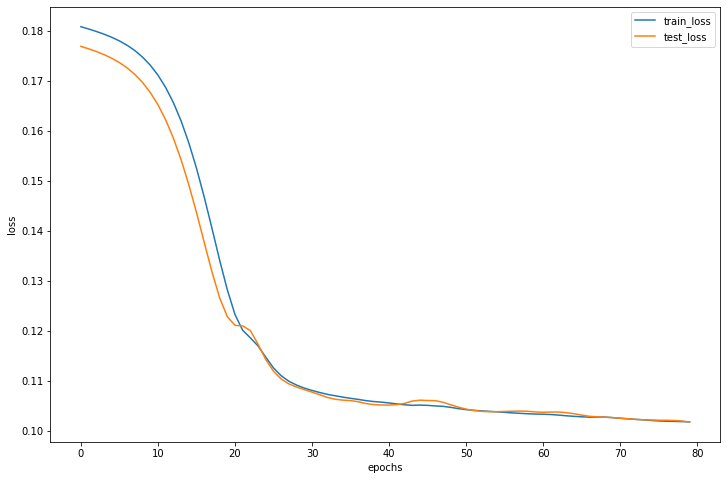

In [15]:
train_loss, test_loss = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [25]:
model.eval()
torch.save(model, jn(tr['models_path'], model_name + '.pt'))

# evoluate model on don't seen data

In [16]:
model = torch.load(jn(tr['models_path'], model_name + '.pt'))

In [17]:
predictions = predict(model, input_test)
predictions.shape

(15, 64, 64)

In [18]:
print(f"Train loss is {loss_fn(torch.from_numpy(predictions), torch.from_numpy(output_test)).item():.4f}")

Train loss is 0.0937


len=  15


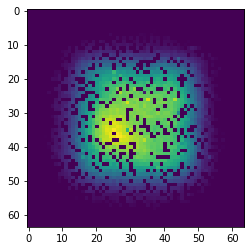

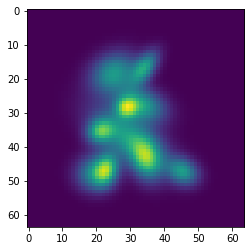

In [19]:
print('len= ', len(predictions))
N = 1  # number of exampel
plt.imshow(predictions[N])
plt.show()
plt.imshow(output_test[N])
plt.show()